# 动量法
使用梯度下降法,每次都会朝着目标函数下降最快的方向,这也称为最速下降法. 这种方法看似非常快,实际上存在一些问题.

## 一.梯度下降法的问题

不同参数的更新方向不同,统一设置一个学习率导致,部分方向参数训练快,部分参数训练慢.

如下图所示:

![](https://ws1.sinaimg.cn/large/006tKfTcly1fmnketw5f4j30az04lq31.jpg)
竖直方向,梯度很大,水平方向,梯度很小.

如此一来,lr太大导致竖直方向参数更新过了,lr太小导致水平方向更新过于缓慢.

- lr太大表现在上图中就是竖直方向震荡次数过多,导致水平方向更新效率低下.
- lr太小表现在上图中就是竖直方向虽然不震荡了,但是水平方向也降速了.

如何让竖直方向减少震荡,水平方向加快更新速度? 动量法缓解了这个问题.

## 二.动量法的解决思路

动量法的提出就是为了应对这个问题，我们梯度下降法做一个修改如下

$$
v_i = \gamma v_{i-1} + \eta \nabla L(\theta)
$$
$$
\theta_i = \theta_{i-1} - v_i
$$

其中 $v_i$ 是当前速度，$\gamma$ 是动量参数，是一个小于 1的正数，$\eta$ 是学习率.

动量法就是在SGD的基础上增加了一个$\gamma v_{i-1}$,目的是稳定在一个方向的梯度,更新速率越来越高;而震荡(梯度不断变化方向)的方向,减缓更新速率.

如此一来,损失更新就如下图:
![](https://ws1.sinaimg.cn/large/006tNc79gy1fmo5l53o76j30ak04gjrh.jpg)

## 三.手动实现动量法momentum

In [10]:
def sgd_momentum(parameters,vs,lr,gamma):
    for param,v in zip(parameters,vs):
        v[:]=gamma*v + lr*param.grad.data #更新v
        param.data=param.data-v

In [13]:
import numpy as np
import torch
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torch import nn
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt

def data_tf(x):
    x=np.array(x,dtype='float32')/255
    x=(x-0.5)/0.5
    x=x.reshape((-1,))
    x=torch.from_numpy(x)
    return x

train_set=MNIST('../data',train=True,transform=data_tf,download=True)
test_set=MNIST('../data',train=True,transform=data_tf,download=True)

criterion=nn.CrossEntropyLoss()

train_data=DataLoader(train_set,batch_size=64,shuffle=True)
net=nn.Sequential(nn.Linear(784,200),
                 nn.ReLU(),
                 nn.Linear(200,10))

#将速度初始化为和参数形状相同的零张量
vs=[]
for param in net.parameters():
    vs.append(torch.zeros_like(param.data))

losses=[]
start=time.time()
for e in range(5):
    train_loss=0
    for im,label in train_data:
        out=net(Variable(im))
        loss=criterion(out,Variable(label))
        net.zero_grad()
        loss.backward()
        sgd_momentum(net.parameters(),vs,0.01,0.9)
        #记录误差
        train_loss+=loss.item()
        losses.append(loss.item())
    print('epoch:{},loss:{:.5f}'.format(e,train_loss/len(train_data)))
print('Used {:.6f}s'.format(time.time()-start))

epoch:0,loss:0.36819
epoch:1,loss:0.17200
epoch:2,loss:0.12382
epoch:3,loss:0.09967
epoch:4,loss:0.08277
Used 29.783745s


可以看到,momentum法下,loss下降非常之快.但是一定小心学习率lr和动量参数$\gamma$, $\gamma$越大更新越快.

## 四. pytorch自带动量法, `torch.optim.SGD(momentum=0.9)`

In [24]:
train_data=DataLoader(train_set,batch_size=64,shuffle=True)

net=nn.Sequential(nn.Linear(784,200),
                 nn.ReLU(),
                 nn.Linear(200,10))

criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(net.parameters(),lr=0.01,momentum=0.9)#加动量

losses=[]
idx=0
start=time.time()

for e in range(5):
    train_loss=0
    for im,label in train_data:
        out=net(Variable(im))
        loss=criterion(out,Variable(label))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()#item()后不要忘记加括号
        if idx%30==0:
            losses.append(loss.item())
        idx+=1
    print('epoch:{},loss:{:.5f}'.format(e,train_loss/len(train_data)))
print('Used {:.5f}s'.format(time.time()-start))

epoch:0,loss:0.36915
epoch:1,loss:0.17818
epoch:2,loss:0.12745
epoch:3,loss:0.10222
epoch:4,loss:0.08689
Used 26.97288s


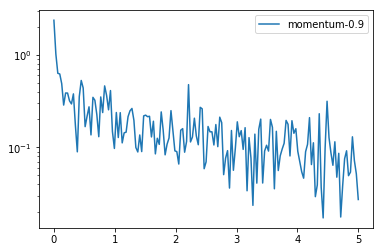

In [25]:
x_axis=np.linspace(0,5,len(losses),endpoint=True)
plt.semilogy(x_axis,losses,label='momentum-0.9')
plt.legend(loc='best')

### 五. 对比不加动量的随机梯度下降法

In [36]:
net=nn.Sequential(nn.Linear(784,200),
                 nn.ReLU(),
                 nn.Linear(200,10))

criterion=nn.CrossEntropyLoss()

optimizer=torch.optim.SGD(net.parameters(),lr=0.01)

losses1=[]
idx=0
start=time.time()
for e in range(5):
    train_loss=0
    for im ,label in train_data:
        out=net(Variable(im))
        loss=criterion(out,Variable(label))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()
        if idx%30==0:
            losses1.append(loss.item())
        idx+=1
    print('epoch:{},loss:{:.5f}'.format(e,train_loss/len(train_data)))
print('Used {:.5f}s'.format(time.time()-start))


epoch:0,loss:0.73720
epoch:1,loss:0.36531
epoch:2,loss:0.31934
epoch:3,loss:0.29070
epoch:4,loss:0.26896
Used 26.81001s


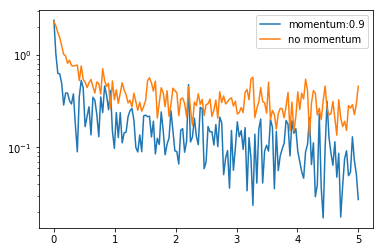

In [38]:
x_axis=np.linspace(0,5,len(losses),endpoint=True)
plt.semilogy(x_axis, losses,label='momentum:0.9')
plt.semilogy(x_axis, losses1,label='no momentum')
plt.legend(loc='best')

可以看到动量法下降得更快,就是因为多了个惯性.

## 小结:
torch.optim.SGD(model.parameters(),lr=0.01,momentum=0.9)